# Import All necessary Moduldes

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import csv
from sklearn.model_selection import train_test_split

#from sklearn.datasets import fetch_mldata
import seaborn as sns
import sklearn as sklearn
from sklearn.neighbors import KNeighborsClassifier
import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

import statsmodels.api as sm
from sklearn import tree
from sklearn.decomposition import PCA

C:\Users\91934\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Import Patient#2 details & display them (Doing analysis on only one patient for now for convenience)

In [2]:
s2_path = 'S2/S2.pkl'
with open(s2_path, 'rb') as file:
    s2_data = pickle.load(file, encoding='latin1')
    
s2_data

{'signal': {'chest': {'ACC': array([[ 0.95539999, -0.222     , -0.55799997],
          [ 0.92579997, -0.2216    , -0.55379999],
          [ 0.90820003, -0.21960002, -0.53920001],
          ...,
          [ 0.87179995, -0.12379998, -0.30419999],
          [ 0.87300003, -0.12339997, -0.30260003],
          [ 0.87020004, -0.12199998, -0.30220002]]),
   'ECG': array([[ 0.02142334],
          [ 0.02032471],
          [ 0.01652527],
          ...,
          [-0.00544739],
          [ 0.00013733],
          [ 0.0040741 ]]),
   'EMG': array([[-0.00444031],
          [ 0.00434875],
          [ 0.00517273],
          ...,
          [-0.01716614],
          [-0.02897644],
          [-0.02357483]]),
   'EDA': array([[5.25054932],
          [5.26733398],
          [5.24330139],
          ...,
          [0.36048889],
          [0.36582947],
          [0.365448  ]]),
   'Temp': array([[30.120758],
          [30.129517],
          [30.138214],
          ...,
          [31.459229],
          [31.484283

In [3]:
print(len(s2_data['label']))
print(sum(s2_data['label']))

4255300
5158996


Text(0.5, 1.0, 'W_Label values')

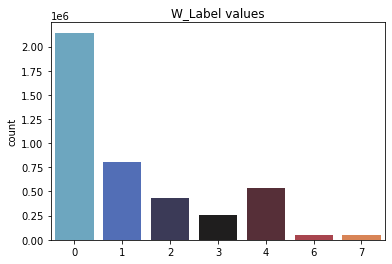

In [4]:
w_label = s2_data['label']

plt.figure()
g = sns.countplot(x = w_label, palette = "icefire") 
plt.title("W_Label values")
# w_label.value_counts()

## To convert to a binary model, we take 0 as non-stressed 1 indicating stress given as label 2 in readme file

In [5]:
w_label = [1 if x == 2 else 0 for x in w_label]

Text(0.5, 1.0, 'W Label values')

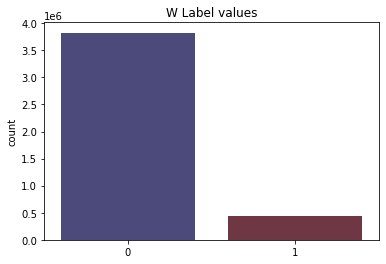

In [6]:
plt.figure()
g = sns.countplot(x = w_label, palette = "icefire") 
plt.title("W Label values")
# w_label.value_counts()

## Extract all features as per the Research Paper

In [7]:
c_ecg = s2_data['signal']['chest']['ECG'][:,0]#[baseline_to_plot]
c_emg = s2_data['signal']['chest']['EMG'][:,0]#[baseline_to_plot]
c_resp = s2_data['signal']['chest']['Resp'][:,0]#[baseline_to_plot]
w_ax = s2_data['signal']['wrist']['ACC'][0:,0]#[stress_to_plot]
w_ay = s2_data['signal']['wrist']['ACC'][0:,1]#[stress_to_plot]
w_az = s2_data['signal']['wrist']['ACC'][0:,2]#[stress_to_plot]
w_bvp = s2_data['signal']['wrist']['BVP'][:,0]#[stress_to_plot]
w_eda = s2_data['signal']['wrist']['EDA'][:,0]#[stress_to_plot]
w_temp = s2_data['signal']['wrist']['TEMP'][:,0]#[stress_to_plot]

## A sliding window having a shift of 1 second was used for segmenting all sensor signals

In [8]:
acc_data = np.column_stack((w_ax, w_ay, w_az))

import numpy as np
from scipy import signal

# Define the original sampling frequencies for each sensor signal
sampling_freq = {
    'ECG': 700,  # RespiBAN ECG: 700 Hz
    'RESP': 700,  # RespiBAN RESP: 700 Hz
    'EMG': 700,  # RespiBAN EMG: 700 Hz
    'TEMP_E4': 4,  # E4 TEMP: 4 Hz
    'EDA_E4': 4,  # E4 EDA: 4 Hz
    'ACC_E4': 32,  # E4 ACC: 32 Hz
    'BVP_E4': 64,  # E4 BVP: 64 Hz
}

# Sample data for each sensor signal (replace with your actual data)
# Ensure the lengths match the original data length

# Define sliding window parameters
window_size = [4, 32, 64, 700]
shift = window_size  # Use the same shift as window size for non-overlapping windows

# Initialize a list to store dataframes for each sensor signal
dfs = []

# Initialize lists to store computed features for each signal
features_acc = []
features_ecg = []
features_resp = []
features_eda = []
features_emg = []
features_temp = []
features_bvp = []

In [9]:
# Segment the data and compute features for each window
for i in range(0, len(acc_data), shift[1]):
    acc_window = acc_data[i:i + window_size[1]]

    try: 
        # Compute statistical features for ACC (separately for each axis and summed)
        acc_features = {
            'mean_acc_x': np.mean(acc_window[:, 0]),
            'std_acc_x': np.std(acc_window[:, 0]),
            'min_acc_x': np.min(acc_window[:, 0]),
            'max_acc_x': np.max(acc_window[:, 0]),
            'mean_acc_y': np.mean(acc_window[:, 1]),
            'std_acc_y': np.std(acc_window[:, 1]),
            'min_acc_y': np.min(acc_window[:, 1]),
            'max_acc_y': np.max(acc_window[:, 1]),
            'mean_acc_z': np.mean(acc_window[:, 2]),
            'std_acc_z': np.std(acc_window[:, 2]),
            'min_acc_z': np.min(acc_window[:, 2]),
            'max_acc_z': np.max(acc_window[:, 2]),
            'sum_acc_3d': np.sum(np.linalg.norm(acc_window, axis=1)),
        }
        features_acc.append(acc_features)
        
    except ValueError: 
        pass
    

# Create a list of time window identifiers
window_ids = range(0, len(acc_data), shift[1])
    

# Create a dataframe for the ACC features
df_acc = pd.DataFrame(features_acc)
df_acc['window_id'] = window_ids  # Add the window identifier
dfs.append(df_acc)

In [10]:
# Segment the data and compute features for each window
for i in range(0, len(c_ecg), shift[3]):
    ecg_window = c_ecg[i:i + window_size[3]]

    try: 
        # Compute statistical features for ECG
        ecg_features = {
            'mean_ecg': np.mean(ecg_window),
            'std_ecg': np.std(ecg_window),
            'min_ecg': np.min(ecg_window),
            'max_ecg': np.max(ecg_window),
        }
        features_ecg.append(ecg_features)
        
    except ValueError: 
        pass
    
# Create a list of time window identifiers
window_ids = range(0, len(c_ecg), shift[3])
    
# Create a dataframe for the ACC features
df_ecg = pd.DataFrame(features_ecg)
df_ecg['window_id'] = window_ids  # Add the window identifier
dfs.append(df_ecg)

In [11]:
# Segment the data and compute features for each window
for i in range(0, len(c_resp), shift[3]):
    resp_window = c_resp[i:i + window_size[3]]

    try: 
        # Compute statistical features for RESP
        resp_features = {
            'mean_resp': np.mean(resp_window),
            'std_resp': np.std(resp_window),
            'min_resp': np.min(resp_window),
            'max_resp': np.max(resp_window),
        }
        features_resp.append(resp_features)
        
    except ValueError: 
        pass

    # Create a list of time window identifiers
window_ids = range(0, len(c_resp), shift[3])

# Create a dataframe for the ACC features
df_resp = pd.DataFrame(features_resp)
df_resp['window_id'] = window_ids  # Add the window identifier
dfs.append(df_resp)

In [12]:
# Segment the data and compute features for each window
for i in range(0, len(w_eda), shift[0]):
    # Define the current window for each sensor signal
    eda_window = w_eda[i:i + window_size[0]]

    try: 
        # Compute statistical features for EDA
        eda_features = {
            'mean_eda': np.mean(eda_window),
            'std_eda': np.std(eda_window),
            'min_eda': np.min(eda_window),
            'max_eda': np.max(eda_window),
        }
        features_eda.append(eda_features)
        
    except ValueError: 
        pass
    
# Create a list of time window identifiers
window_ids = range(0, len(w_eda), shift[0])    

# Create a dataframe for the ACC features
df_eda = pd.DataFrame(features_eda)
df_eda['window_id'] = window_ids  # Add the window identifier
dfs.append(df_eda)

In [13]:
# Segment the data and compute features for each window
for i in range(0, len(c_emg), shift[3]):
    emg_window = c_emg[i:i + window_size[3]]

    try:         
        emg_features = {
            'mean_emg': np.mean(emg_window),
            'std_emg': np.std(emg_window),
            'min_emg': np.min(emg_window),
            'max_emg': np.max(emg_window),
            'peak_freq_emg': np.argmax(np.abs(np.fft.fft(emg_window))),
        }
        features_emg.append(emg_features)
        
    except ValueError: 
        pass
    
# Create a list of time window identifiers
window_ids = range(0, len(c_emg), shift[3])

# Create a dataframe for the ACC features
df_emg = pd.DataFrame(features_emg)
df_emg['window_id'] = window_ids  # Add the window identifier
dfs.append(df_emg)

In [14]:
from scipy.stats import linregress

# Segment the data and compute features for each window
features_temp = []
for i in range(0, len(w_temp), shift[0]):
    temp_window = w_temp[i:i + window_size[0]]
    x = np.arange(window_size[0])  # x-values
    y = temp_window  # y-values

    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    try: 
        # Compute statistical features for E4 TEMP (similar to TEMP)
        temp_features = {
            'mean_temp': np.mean(temp_window),
            'std_temp': np.std(temp_window),
            'min_temp': np.min(temp_window),
            'max_temp': np.max(temp_window),
            'slope_temp': slope
        }
        features_temp.append(temp_features)
        
    except ValueError: 
        pass

# Create a list of time window identifiers
window_ids = range(0, len(w_temp), shift[0])
    
# Create a dataframe for the ACC features
df_temp = pd.DataFrame(features_temp)
df_temp['window_id'] = window_ids  # Add the window identifier
dfs.append(df_temp)

In [15]:
# Segment the data and compute features for each window
for i in range(0, len(w_bvp), shift[2]):
    bvp_window = w_bvp[i:i + window_size[2]]

    try: 
        # Compute statistical features for E4 BVP
        bvp_features = {
            'mean_bvp': np.mean(bvp_window),
            'std_bvp': np.std(bvp_window),
            'min_bvp': np.min(bvp_window),
            'max_bvp': np.max(bvp_window),
            'peak_freq_bvp': np.argmax(np.abs(np.fft.fft(bvp_window))),
        }
        features_bvp.append(bvp_features)
        
    except ValueError: 
        pass

# Create a list of time window identifiers
window_ids = range(0, len(w_bvp), shift[2])

# Create a dataframe for the ACC features
df_bvp = pd.DataFrame(features_bvp)
df_bvp['window_id'] = window_ids  # Add the window identifier
dfs.append(df_bvp)

In [16]:
for df in dfs[0:]:
    print(df.shape)

(6079, 14)
(6079, 5)
(6079, 5)
(6079, 5)
(6079, 6)
(6079, 6)
(6079, 6)


## Repeat a calculated statistical value for the entire window as discussed

In [17]:
# Number of times to repeat the values
n = 700

# Function to repeat every column value n times for a DataFrame
def repeat_values(df, n):
    return df.apply(lambda x: x.repeat(n), axis = 0)

# Repeat values for each DataFrame in the list
repeated_df_list = [repeat_values(df, n) for df in dfs]

## Create final datafram with 40 features

In [18]:
result_df = pd.concat([repeated_df_list[0], repeated_df_list[1], repeated_df_list[2], repeated_df_list[3], repeated_df_list[4], dfs[5], repeated_df_list[6]], axis=1)

df = result_df.drop(columns=['window_id'])

display(df.shape)
display(df.info)
display(df.describe)

df.columns

(4255300, 40)

<bound method DataFrame.info of       mean_acc_x  std_acc_x  min_acc_x  max_acc_x  mean_acc_y  std_acc_y  \
0       52.18750  13.918148       -3.0       81.0    13.56250  13.631163   
0       52.18750  13.918148       -3.0       81.0    13.56250  13.631163   
0       52.18750  13.918148       -3.0       81.0    13.56250  13.631163   
0       52.18750  13.918148       -3.0       81.0    13.56250  13.631163   
0       52.18750  13.918148       -3.0       81.0    13.56250  13.631163   
...          ...        ...        ...        ...         ...        ...   
6078    50.21875   8.695309       39.0       87.0    18.65625   4.413115   
6078    50.21875   8.695309       39.0       87.0    18.65625   4.413115   
6078    50.21875   8.695309       39.0       87.0    18.65625   4.413115   
6078    50.21875   8.695309       39.0       87.0    18.65625   4.413115   
6078    50.21875   8.695309       39.0       87.0    18.65625   4.413115   

      min_acc_y  max_acc_y  mean_acc_z  std_acc_z  ... 

<bound method NDFrame.describe of       mean_acc_x  std_acc_x  min_acc_x  max_acc_x  mean_acc_y  std_acc_y  \
0       52.18750  13.918148       -3.0       81.0    13.56250  13.631163   
0       52.18750  13.918148       -3.0       81.0    13.56250  13.631163   
0       52.18750  13.918148       -3.0       81.0    13.56250  13.631163   
0       52.18750  13.918148       -3.0       81.0    13.56250  13.631163   
0       52.18750  13.918148       -3.0       81.0    13.56250  13.631163   
...          ...        ...        ...        ...         ...        ...   
6078    50.21875   8.695309       39.0       87.0    18.65625   4.413115   
6078    50.21875   8.695309       39.0       87.0    18.65625   4.413115   
6078    50.21875   8.695309       39.0       87.0    18.65625   4.413115   
6078    50.21875   8.695309       39.0       87.0    18.65625   4.413115   
6078    50.21875   8.695309       39.0       87.0    18.65625   4.413115   

      min_acc_y  max_acc_y  mean_acc_z  std_acc_z  ..

Index(['mean_acc_x', 'std_acc_x', 'min_acc_x', 'max_acc_x', 'mean_acc_y',
       'std_acc_y', 'min_acc_y', 'max_acc_y', 'mean_acc_z', 'std_acc_z',
       'min_acc_z', 'max_acc_z', 'sum_acc_3d', 'mean_ecg', 'std_ecg',
       'min_ecg', 'max_ecg', 'mean_resp', 'std_resp', 'min_resp', 'max_resp',
       'mean_eda', 'std_eda', 'min_eda', 'max_eda', 'mean_emg', 'std_emg',
       'min_emg', 'max_emg', 'peak_freq_emg', 'mean_temp', 'std_temp',
       'min_temp', 'max_temp', 'slope_temp', 'mean_bvp', 'std_bvp', 'min_bvp',
       'max_bvp', 'peak_freq_bvp'],
      dtype='object')

In [19]:
len(w_label)
print(sum(w_label))

w_label = np.array(w_label)

430500


## Extract Features & Labels

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Extract features and labels
X = df[['mean_acc_x', 'std_acc_x', 'min_acc_x', 'max_acc_x', 'mean_acc_y',
       'std_acc_y', 'min_acc_y', 'max_acc_y', 'mean_acc_z', 'std_acc_z',
       'min_acc_z', 'max_acc_z', 'sum_acc_3d', 'mean_ecg', 'std_ecg',
       'min_ecg', 'max_ecg', 'mean_resp', 'std_resp', 'min_resp', 'max_resp',
       'mean_eda', 'std_eda', 'min_eda', 'max_eda', 'mean_emg', 'std_emg',
       'min_emg', 'max_emg', 'peak_freq_emg', 'mean_temp', 'std_temp',
       'min_temp', 'max_temp', 'slope_temp', 'mean_bvp', 'std_bvp', 'min_bvp',
       'max_bvp', 'peak_freq_bvp']]

y = w_label

## Creating model based on the above data and as per the Research Paper

## Split the data into training and testing sets

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network model for binary classification:

In [22]:
binary_model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1, activation='sigmoid')
])

binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = binary_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
106383/106383 [==============================] - 151s 1ms/step - loss: 0.2643 - accuracy: 0.9719 - val_loss: 0.0472 - val_accuracy: 0.9821
Epoch 2/10
106383/106383 [==============================] - 170s 2ms/step - loss: 0.0512 - accuracy: 0.9814 - val_loss: 0.0425 - val_accuracy: 0.9836
Epoch 3/10
106383/106383 [==============================] - 155s 1ms/step - loss: 0.0457 - accuracy: 0.9840 - val_loss: 0.0422 - val_accuracy: 0.9847
Epoch 4/10
106383/106383 [==============================] - 191s 2ms/step - loss: 0.0415 - accuracy: 0.9860 - val_loss: 0.0318 - val_accuracy: 0.9905
Epoch 5/10
106383/106383 [==============================] - 176s 2ms/step - loss: 0.0396 - accuracy: 0.9870 - val_loss: 0.0281 - val_accuracy: 0.9902
Epoch 6/10
106383/106383 [==============================] - 152s 1ms/step - loss: 0.0383 - accuracy: 0.9873 - val_loss: 0.0288 - val_accuracy: 0.9910
Epoch 7/10
106383/106383 [==============================] - 159s 1ms/step - loss: 0.0360 - accuracy:

In [23]:
from sklearn.metrics import f1_score

y_pred = binary_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels (you may need to adjust the threshold)

# Calculate the F1-score
f1 = f1_score(y_test, y_pred)

print("F1-Score:", f1)

26596/26596 [==============================] - 21s 772us/step
F1-Score: 0.965659974129689


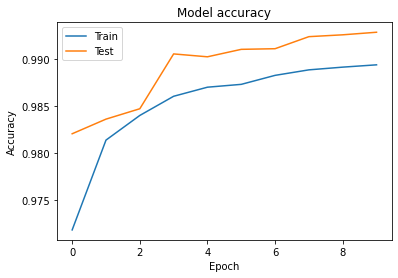

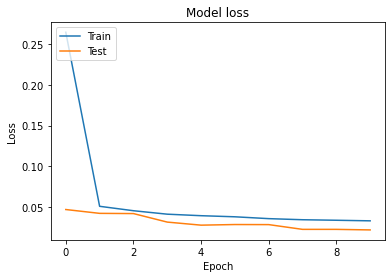

In [24]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

26596/26596 [==============================] - 24s 891us/step


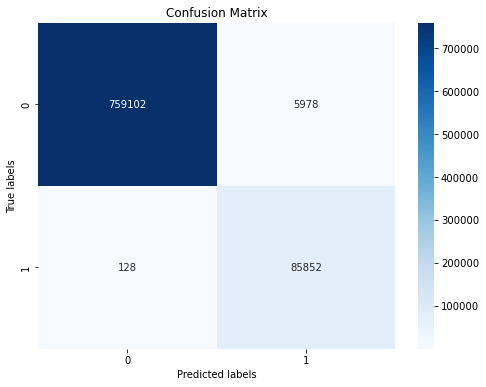

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions on the test set
y_pred = binary_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()